# Classify water as hot or cold (from the sound of pouring) - Part 2


## Context

This is a continuation of the previous build log. In the previous notebook, it became apparent that linear classification of temperature from audio of water pouring wouldn't be practical to do.

In this notebook, we'll take a look at an improved data set that has far more samples. Hopefully a binary classification into "hot" or "cold" (defined here as "hot" > 100 degrees f) is something we can achieve!

## Dependencies

* Fast.ai `conda install -c fastai fastai`
    * Important note: fastai requires Python 3.6.*
* pytorch ([installation instructions](https://pytorch.org/))
* LibROSA `conda install librosa`

## Notebook Setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
print("cuda available") if torch.cuda.is_available() else print("cuda not available")

print(torch.cuda.get_device_name(0))
print('Memory Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
print('Memory Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

cuda available
GeForce GTX 970
Memory Allocated: 0.0 GB
Memory Cached:    0.0 GB


In [4]:
dataPath = Path('data-v2'); print(dataPath)
audioPath = dataPath/'audio'; print(audioPath)
spectrogramPath = dataPath/'spectrograms'; print(spectrogramPath)
spectrogramPath.mkdir(parents=True, exist_ok=True)

data-v2
data-v2\audio
data-v2\spectrograms


## Generate spectrograms for each audio sample
And save them in a folder that lives alongside the audio data

In [5]:
# Constants
min_frequency=256
max_frequency = 16384
samples_between_frames = 256
fft_window_size = 2048

In [6]:
import os
import librosa
import librosa.display
import matplotlib.pyplot

def generate_and_save_libROSA_spectrogram(audioFilePath):
    print('Generating spectrogram for: ' + str(audioFilePath))

    # Load the audio, generate a spectrogram in DB (to match the logarithmic nature of human hearing)
    audio_data, sample_rate = librosa.load(audioFilePath, sr=None)
    spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_mels=128, fmax=max_frequency,
                                             hop_length=samples_between_frames, n_fft=fft_window_size)
    amplitude_in_db = librosa.power_to_db(spectrogram, ref=np.max)

    # Generate the spectrogram with min and max frequency bounds applied
    librosa.display.specshow(amplitude_in_db, x_axis=None, y_axis=None, sr=sample_rate, fmin=min_frequency, fmax=max_frequency)
    plt.tight_layout()
    
    # Save the generated spectrogram
    spectrogramSavePath = Path(spectrogramPath/(os.path.splitext(os.path.basename(audioFilePath))[0] + '.png'))
    print('Saving spectrogram as: ' + str(spectrogramSavePath))
    plt.savefig(spectrogramSavePath)
    plt.close()


for fileName in os.listdir(audioPath):
    if re.match(r"\d+-[a-zA-Z]+\d+.m4a", fileName):
        fullName = audioPath/fileName
        generate_and_save_libROSA_spectrogram(fullName)

Generating spectrogram for: data-v2\audio\175-ceramic1.m4a
Saving spectrogram as: data-v2\spectrograms\175-ceramic1.png
Generating spectrogram for: data-v2\audio\175-ceramic2.m4a
Saving spectrogram as: data-v2\spectrograms\175-ceramic2.png
Generating spectrogram for: data-v2\audio\175-ceramic3.m4a
Saving spectrogram as: data-v2\spectrograms\175-ceramic3.png
Generating spectrogram for: data-v2\audio\175-ceramic4.m4a
Saving spectrogram as: data-v2\spectrograms\175-ceramic4.png
Generating spectrogram for: data-v2\audio\175-ceramic5.m4a
Saving spectrogram as: data-v2\spectrograms\175-ceramic5.png
Generating spectrogram for: data-v2\audio\175-ceramic6.m4a
Saving spectrogram as: data-v2\spectrograms\175-ceramic6.png
Generating spectrogram for: data-v2\audio\175-glass1.m4a
Saving spectrogram as: data-v2\spectrograms\175-glass1.png
Generating spectrogram for: data-v2\audio\175-glass2.m4a
Saving spectrogram as: data-v2\spectrograms\175-glass2.png
Generating spectrogram for: data-v2\audio\195-ce

Saving spectrogram as: data-v2\spectrograms\40-glass7.png
Generating spectrogram for: data-v2\audio\40-glass8.m4a
Saving spectrogram as: data-v2\spectrograms\40-glass8.png
Generating spectrogram for: data-v2\audio\40-glass9.m4a
Saving spectrogram as: data-v2\spectrograms\40-glass9.png
Generating spectrogram for: data-v2\audio\73-ceramic1.m4a
Saving spectrogram as: data-v2\spectrograms\73-ceramic1.png
Generating spectrogram for: data-v2\audio\73-ceramic2.m4a
Saving spectrogram as: data-v2\spectrograms\73-ceramic2.png
Generating spectrogram for: data-v2\audio\75-ceramic1.m4a
Saving spectrogram as: data-v2\spectrograms\75-ceramic1.png
Generating spectrogram for: data-v2\audio\75-ceramic10.m4a
Saving spectrogram as: data-v2\spectrograms\75-ceramic10.png
Generating spectrogram for: data-v2\audio\75-ceramic11.m4a
Saving spectrogram as: data-v2\spectrograms\75-ceramic11.png
Generating spectrogram for: data-v2\audio\75-ceramic12.m4a
Saving spectrogram as: data-v2\spectrograms\75-ceramic12.png


## Do Some ML!

In [7]:
np.random.seed(369)

In [8]:
def hot_or_cold_re(file_name):
    pattern = re.compile(r'.*[\\|/](\d+)-[a-zA-Z]+\d+.png')
    temp = pattern.search(str(file_name)).group(1)
    return 'hot' if int(temp) > 100 else 'cold'

print(hot_or_cold_re(spectrogramPath/'75-glass1.png'))
print(hot_or_cold_re(spectrogramPath/'175-glass1.png'))

cold
hot


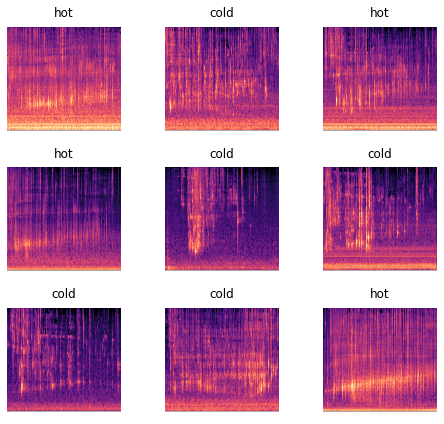

In [9]:
# Make a data bunch of all the spectrograms, and label them with their temperature via regex

transforms = get_transforms(
    do_flip=False,
    flip_vert=False,
    max_rotate=None,
    max_lighting=None,
    max_warp=None,
    max_zoom=1.)

data = (ImageList
    .from_folder(spectrogramPath)
    .split_by_rand_pct()
    .label_from_func(hot_or_cold_re)
    .transform(transforms, size=224)
    .databunch()
).normalize(imagenet_stats)

data.show_batch(rows=3, figsize=(7,6))

In [10]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate,time
0,1.338632,0.895588,0.578947,00:17
1,1.347192,0.588757,0.210526,00:14
2,0.954138,1.338454,0.473684,00:14
3,0.751784,2.354969,0.526316,00:14
4,0.597949,2.705106,0.526316,00:14
5,0.499281,2.559820,0.578947,00:14


## Let's dig into the results:

In [11]:
interp = ClassificationInterpretation.from_learner(learn)

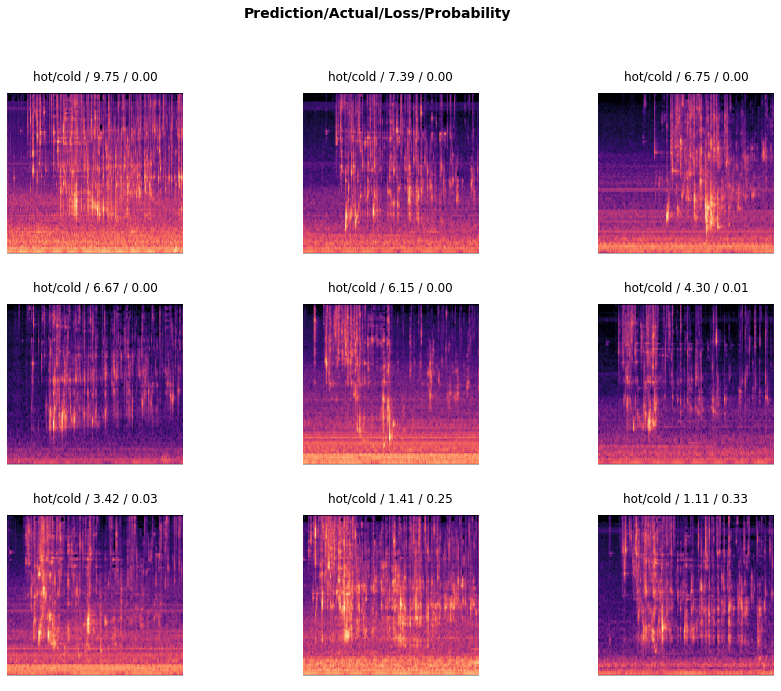

In [12]:
interp.plot_top_losses(9, figsize=(15,11))

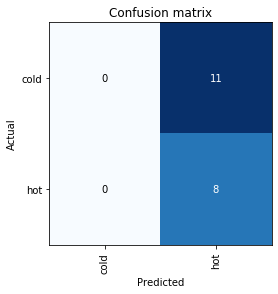

In [13]:
interp.plot_confusion_matrix()

In [14]:
interp.most_confused(min_val=2)

[('cold', 'hot', 11)]

## Not good, perhaps the earlier layers need training to identify relevant features

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


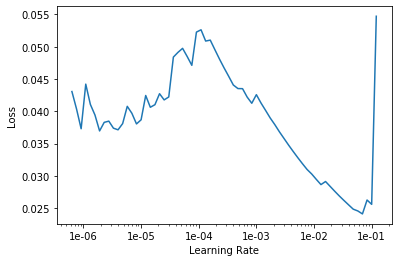

In [15]:
learn.lr_find()
learn.recorder.plot()

*(Note to future viewers, I re-ran this whole notebook to verify I had reproducible results, and now the cell above has results! LR Find originally generated an empty graph.)*

Looks like nothing was found (LR find appears to stop searching once loss increases by some threshold). We're trapped in a local optimum!

Let's wing it, and train using the values from Fast.ai's lesson 1.

In [16]:
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.030328,2.286965,0.526316,00:15
1,0.026258,1.997443,0.421053,00:14
2,0.020001,1.773574,0.315789,00:14
3,0.016979,1.519815,0.315789,00:14
4,0.016715,1.354283,0.263158,00:14
5,0.017437,1.205124,0.263158,00:14
6,0.016701,1.013034,0.210526,00:14
7,0.031407,0.895095,0.210526,00:14
8,0.027936,0.731154,0.210526,00:14
9,0.030328,0.591768,0.157895,00:14


## NICE! It's improving!
Let's save that, and fine-tune further

In [17]:
learn.save('resnet34-unfreeze1')

In [18]:
learn.lr_find(
    start_lr=1e-10,
    end_lr=1,
    stop_div=False, ## Force LR Find to search, even if it thinks it's at an optimum
    num_it=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


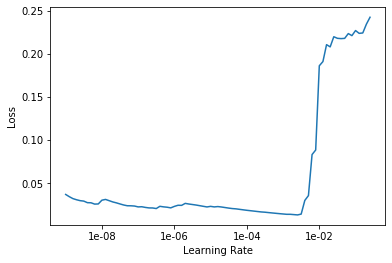

In [19]:
learn.recorder.plot()

Nothing too promising, but let's give that last downward slope before the spike a try:

In [20]:
learn.fit_one_cycle(10, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.002211,0.458950,0.157895,00:14
1,0.003712,0.335018,0.157895,00:14
2,0.003349,0.293921,0.157895,00:14
3,0.003705,0.239378,0.105263,00:14
4,0.002973,0.157313,0.105263,00:14
5,0.002800,0.117436,0.105263,00:14
6,0.003251,0.077107,0.052632,00:14
7,0.003155,0.042028,0.000000,00:14
8,0.002787,0.022905,0.000000,00:14
9,0.002506,0.015221,0.000000,00:14


The losses keep falling! Let's save that, and try a final round of training for much longer.

In [21]:
learn.save('resnet34-unfreeze2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


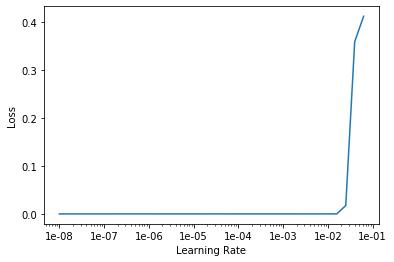

In [29]:
learn.lr_find(
    start_lr=1e-10,
    end_lr=1,
    stop_div=False, ## Force LR Find to search, even if it thinks it's at an optimum
    num_it=50)
learn.recorder.plot()

Not much to act on in this graph, let's narrow the search a bit

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


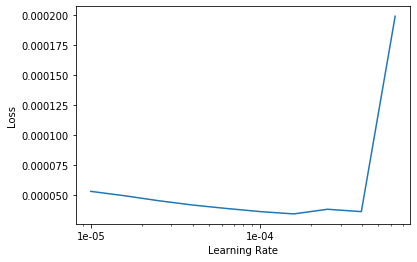

In [30]:
learn.lr_find(
    start_lr=1e-7,
    end_lr=1e-2,
    stop_div=False, ## Force LR Find to search, even if it thinks it's at an optimum
    num_it=25)
learn.recorder.plot()

Looks like LR Find won't be much help. We'll use the whole range that got graphed, while ensuring we don't go near the massive spike in loss that occurs as LR nears 1e-2.

In [23]:
learn.fit_one_cycle(50, max_lr=slice(5e-5,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.001040,0.011632,0.000000,00:14
1,0.001393,0.007315,0.000000,00:14
2,0.001244,0.004234,0.000000,00:14
3,0.001108,0.002665,0.000000,00:14
4,0.000943,0.002273,0.000000,00:14
5,0.000832,0.001944,0.000000,00:14
6,0.000710,0.001552,0.000000,00:14
7,0.000637,0.000946,0.000000,00:14
8,0.000563,0.000660,0.000000,00:14
9,0.000538,0.000465,0.000000,00:14


## This is Excellent!
Let's save the model, and dig into the errors it's making

In [24]:
learn.save('resnet34-unfreeze3')

In [25]:
interp = ClassificationInterpretation.from_learner(learn)

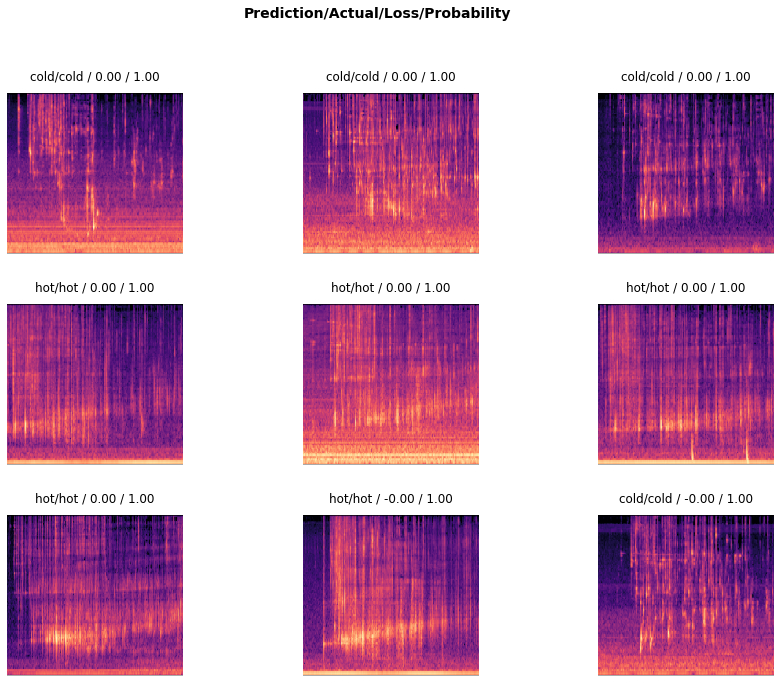

In [26]:
interp.plot_top_losses(9, figsize=(15,11))

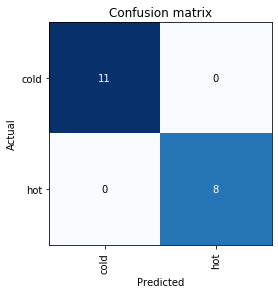

In [27]:
interp.plot_confusion_matrix()

In [28]:
interp.most_confused()

[]

## Wow! No errors!
There is one thing to fear: over-fitting. Even though the validation set is unseen by the algorithm, I think it's good to take this trained model and give it a try on some completely new data recorded on a different day. Luckily, we have some spare data sitting around in the old `/data/audio` folder that fits the bill.

Let's export the model and move on to the third and final build log!

In [31]:
learn.export()